<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Создание-разметки" data-toc-modified-id="Создание-разметки-1">Создание разметки</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1">Загрузка данных</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-1.2">Функции</a></span><ul class="toc-item"><li><span><a href="#Get" data-toc-modified-id="Get-1.2.1">Get</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.2.2">Outliers</a></span></li><li><span><a href="#Уменьшение-категорий-в-фичах" data-toc-modified-id="Уменьшение-категорий-в-фичах-1.2.3">Уменьшение категорий в фичах</a></span></li></ul></li><li><span><a href="#Количество-потоков-в-вычислении" data-toc-modified-id="Количество-потоков-в-вычислении-1.3">Количество потоков в вычислении</a></span></li><li><span><a href="#Sample_100" data-toc-modified-id="Sample_100-1.4">Sample_100</a></span></li><li><span><a href="#Sample_500" data-toc-modified-id="Sample_500-1.5">Sample_500</a></span></li><li><span><a href="#Sample_10k" data-toc-modified-id="Sample_10k-1.6">Sample_10k</a></span></li></ul></li><li><span><a href="#Работа-с-размеченными-данными" data-toc-modified-id="Работа-с-размеченными-данными-2">Работа с размеченными данными</a></span><ul class="toc-item"><li><span><a href="#Загрузка-размеченных-данных" data-toc-modified-id="Загрузка-размеченных-данных-2.1">Загрузка размеченных данных</a></span></li><li><span><a href="#Создание-фичей" data-toc-modified-id="Создание-фичей-2.2">Создание фичей</a></span></li><li><span><a href="#Разработка-модели" data-toc-modified-id="Разработка-модели-2.3">Разработка модели</a></span><ul class="toc-item"><li><span><a href="#Features-&amp;-Target" data-toc-modified-id="Features-&amp;-Target-2.3.1">Features &amp; Target</a></span></li><li><span><a href="#Train-&amp;-Test" data-toc-modified-id="Train-&amp;-Test-2.3.2">Train &amp; Test</a></span></li><li><span><a href="#Подбор-гипперпараметров-модели" data-toc-modified-id="Подбор-гипперпараметров-модели-2.3.3">Подбор гипперпараметров модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.4">Тестирование модели</a></span></li></ul></li></ul></div>

# Создание разметки

In [1]:
import os
import re
import time
import math
import requests
import numpy as np
import pandas as pd
from IPython.display import HTML

from concurrent.futures import ThreadPoolExecutor

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

#import plotly
#import plotly.offline as py #working offline
#import plotly.graph_objs as go
#import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#py.init_notebook_mode()
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Загрузка данных

In [25]:
path = r'd:\Мои документы\datasets\mtc'

file_name = 'host_hachathon.csv'
all_data = 'host.csv'

df = pd.read_csv(os.path.join(path, file_name), header = None, names=['domen_name'])
all_data = pd.read_csv(os.path.join(path, all_data), header = None, names=['domen_name'])

In [5]:
#df_sample = all_data.iloc[30000:40000,:].copy()

## Функции

### Get

In [6]:
def get_func(x):
    try:
        r = requests.get(x, timeout=3)#.headers['Content-Type']
        r.headers['Content-Type']
        return 0, r.status_code
    except:
        return 1, None

### Outliers

In [7]:
def drop_outliers(series, n_of_iqr=1.5):
    q75, q25 = np.nanpercentile(series,(75,25))
    iqr = q75 - q25

    max_value = q75 + (n_of_iqr * iqr)
    min_value = q25 - (n_of_iqr * iqr)

    series.loc[series < min_value] = np.nan
    series.loc[series > max_value] = np.nan

### Уменьшение категорий в фичах

In [8]:
def cat_featering(feature_name):
    series = df_sample[feature_name].value_counts(normalize=True).copy()
    drop_outliers(series)

    df_sample[feature_name] = df_sample[feature_name].apply(lambda x: 'OTHER' if x in series.dropna().index else x)
    del series
    #return df_sample[feature_name].value_counts(normalize=True)

## Количество потоков в вычислении

In [9]:
Thread = 32

## Sample_100

```python
df['url'] = df.iloc[:,0].apply(lambda x: f'http://{x}')
urls = df['url'].to_list()

start_time = time.time()

with ThreadPoolExecutor(Thread) as executor:
    result = executor.map(get_func, urls)

df['label'] = pd.Series(result)
df['status_code'] = df['label'].apply(lambda x: str(x[1]))
df['label'] = df['label'].apply(lambda x: x[0])

spent_time = time.time() - start_time

display(spent_time)
df
```

## Sample_500

```python
all_data['url'] = all_data.iloc[:,0].apply(lambda x: f'http://{x}')
#url_33 = all_data[all_data.iloc[:,0].str.split('.').apply(len) == 33].iloc[:,1].to_list()
url_2 = all_data[all_data.iloc[:,0].str.split('.').apply(len) == 2].\
    sample(n=500, random_state=42).reset_index(drop=True).iloc[:,1].to_list()

start_time = time.time()

with ThreadPoolExecutor(Thread) as executor:
    result = executor.map(get_func, url_2)

spent_time = time.time() - start_time

display(spent_time)
pd.DataFrame(result, columns=['label', 'status_code'])
```

## Sample_10k

```python
df_sample['url'] = df_sample.iloc[:,0].apply(lambda x: f'http://{x}')
urls = df_sample['url'].to_list()

start_time = time.time()

with ThreadPoolExecutor(Thread) as executor:
    result = executor.map(get_func, urls)

df_sample['label'] = pd.Series(result, index=df_sample.index)
df_sample['status_code'] = df_sample['label'].apply(lambda x: str(x[1]))
df_sample['label'] = df_sample['label'].apply(lambda x: x[0])

spent_time = time.time() - start_time

display(spent_time)
df_sample
```

In [10]:
#file_name = 'df_with_label_30_40.csv'
#df_sample.to_csv(os.path.join(path, file_name), index=True)

# Работа с размеченными данными

## Загрузка размеченных данных

In [11]:
path = r'd:\Мои документы\datasets\mtc'
file_name = 'df_with_label_30_40.csv'

df_sample = pd.read_csv(os.path.join(path, file_name)).drop(columns=['Unnamed: 0'])
df_sample

,domen_name,url,label,status_code
0,api.browser.yandex.ru,http://api.browser.yandex.ru,1,None
1,sync.connectad.io,http://sync.connectad.io,0,200
2,statics.teams.microsoft.com,http://statics.teams.microsoft.com,1,None
3,0.pool.ntp.org,http://0.pool.ntp.org,0,200
4,web-gw-ru-21-13.voximplant.com,http://web-gw-ru-21-13.voximplant.com,1,None
...,...,...,...,...
9995,d280pffqtvekyf.cloudfront.net,http://d280pffqtvekyf.cloudfront.net,0,403
9996,yandex.st,http://yandex.st,0,200
9997,ocsp.usertrust.com,http://ocsp.usertrust.com,0,200
9998,cloud-api.yandex.net,http://cloud-api.yandex.net,1,None


In [12]:
df_sample['label'].value_counts()

0    7427
1    2573
Name: label, dtype: int64

## Создание фичей

In [13]:
df_sample['domen_name'] = df_sample['domen_name'].str.strip()
df_sample['top_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-1])
df_sample['2_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-2])
df_sample['3_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-3] if len(x.split('.')) > 2 else None)

df_sample['domen_len'] = df_sample['domen_name'].apply(lambda x: len(x.split('.')))
df_sample['len_coeff'] = df_sample['domen_name'].apply(lambda x: len(''.join(x.split('.'))) / len(x.split('.')))

In [14]:
df_sample.isna().sum()

domen_name       0
url              0
label            0
status_code      0
top_domen        0
2_domen          0
3_domen        683
domen_len        0
len_coeff        0
dtype: int64

In [15]:
df_sample['3_domen'].fillna('EMPTY', inplace=True)

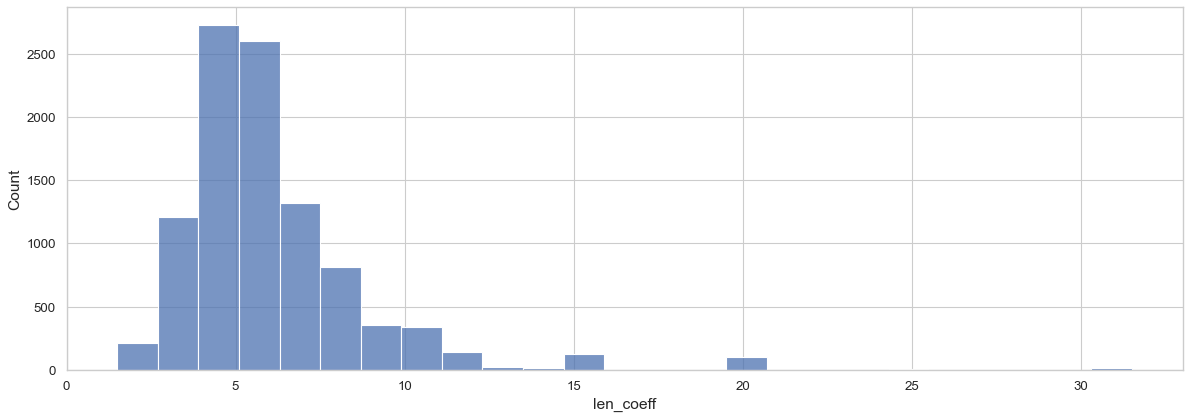

In [16]:
sns.histplot(df_sample['len_coeff'], bins=25)
plt.show()

In [17]:
cat_featering('top_domen')
cat_featering('2_domen')
cat_featering('3_domen')

In [18]:
cat_features = ['top_domen', '2_domen', '3_domen']#'status_code',
num_features = ['domen_len', 'len_coeff']

df_sample[cat_features] = df_sample[cat_features].astype('category')

In [19]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   domen_name   10000 non-null  object  
 1   url          10000 non-null  object  
 2   label        10000 non-null  int64   
 3   status_code  10000 non-null  object  
 4   top_domen    10000 non-null  category
 5   2_domen      10000 non-null  category
 6   3_domen      10000 non-null  category
 7   domen_len    10000 non-null  int64   
 8   len_coeff    10000 non-null  float64 
dtypes: category(3), float64(1), int64(2), object(3)
memory usage: 535.1+ KB


In [20]:
df_sample

,domen_name,url,label,status_code,top_domen,2_domen,3_domen,domen_len,len_coeff
0,api.browser.yandex.ru,http://api.browser.yandex.ru,1,None,ru,yandex,browser,4,4.500000
1,sync.connectad.io,http://sync.connectad.io,0,200,io,OTHER,sync,3,5.000000
2,statics.teams.microsoft.com,http://statics.teams.microsoft.com,1,None,com,microsoft,teams,4,6.000000
3,0.pool.ntp.org,http://0.pool.ntp.org,0,200,org,ntp,pool,4,2.750000
4,web-gw-ru-21-13.voximplant.com,http://web-gw-ru-21-13.voximplant.com,1,None,com,voximplant,OTHER,3,9.333333
...,...,...,...,...,...,...,...,...,...
9995,d280pffqtvekyf.cloudfront.net,http://d280pffqtvekyf.cloudfront.net,0,403,net,cloudfront,OTHER,3,9.000000
9996,yandex.st,http://yandex.st,0,200,st,yandex,EMPTY,2,4.000000
9997,ocsp.usertrust.com,http://ocsp.usertrust.com,0,200,com,OTHER,ocsp,3,5.333333
9998,cloud-api.yandex.net,http://cloud-api.yandex.net,1,None,net,yandex,OTHER,3,6.000000


## Разработка модели

### Features & Target

In [21]:
features = df_sample.drop(columns=['domen_name', 'url', 'label', 'status_code'])
target = df_sample['label']

### Train & Test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

### Подбор гипперпараметров модели

In [23]:
best_score = 0
estimators = 0
start_time = time.time()

for i in np.arange(180, 320, 20):
    model = CatBoostClassifier(n_estimators=i,
                              learning_rate=0.99,
                              depth=3,
                              cat_features=cat_features,
                              verbose=False,
                              random_state=12345,
#                              loss_function='RMSE',
                             )

    n_scores = cross_val_score(model,
                               X_train,
                               y_train,
                               scoring='precision_macro',
                               cv=5,
                               n_jobs=-1,
                               error_score='raise'
                              )

    score = np.mean(np.abs(n_scores))

    if score > best_score:
        best_score = score
        estimators = i

fit_time = time.time() - start_time

display(HTML(f'<b>Гиппер параметр n_estimators: </b> <code>{estimators}</code>'))
display(HTML(f'<b>Лучший precision_score: </b> <code>{best_score:,.3f}</code>'))
display(HTML(f'<b>Время обучения: </b> <code>{fit_time:,.3f}</code> c'))

## Тестирование модели

In [24]:
model = CatBoostClassifier(n_estimators=estimators,
                          learning_rate=0.95,
                          depth=3,
                          cat_features=cat_features,
                          verbose=False,
                          random_state=12345,
                         )
model.fit(X_train, y_train)
score_test = precision_score(y_test, model.predict(X_test), average='macro')

display(HTML(f'<b>precision_score на тестовой выборке: </b> <code>{score_test:,.3f}</code>'))